In [1]:
import tensorflow as tf
from tensorflow import keras

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv2D(filters, 3, strides=strides, padding='same', use_bias=False),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv2D(filters, 3, strides=strides, padding='same', use_bias=False),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv2D(filters, 1, strides=strides, padding='same', use_bias=False),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

def createResNet34():
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='SAME',
                            input_shape=[224, 224, 3]))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation("relu"))
    model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
    prev_filters = 64
    for filters in [64] * 3:
        strides = 1 if filters == prev_filters else 2
        model.add(ResidualUnit(filters, strides=strides))
        prev_filters = filters
    model.add(keras.layers.GlobalAvgPool2D())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(10, activation="softmax"))
    return model

In [3]:
# Utiliser un modèle CNN préentrainé pour faire du transfer learning

import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

Dl Completed...: 100%|██████████| 5/5 [00:05<00:00,  1.19s/ file]

Dataset tf_flowers downloaded and prepared to /home/johnny/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [5]:
dataset_size = info.splits["train"].num_examples #3670
class_names = info.features["label"].names #["dandelion", "daisy", ...]
n_classes = info.features["label"].num_classes #5

In [36]:
class_names[0]

'dandelion'

In [2]:
def disp_dataset(ds, limit=None, print_elements=True):
    count = 0

    for x in ds:
        count += 1
        if print_elements:
            print(x)
        if limit is not None and count >= limit:
            break
    print(f"Count:{count}")

def batch_sets(list_ds):
    my_list = []
    for x in list_ds:
        new_ds = x.batch(32).prefetch(1)
        my_list.append(new_ds)
    return my_list

# Redimensionner l'image

def preprocess(image, label):
    # label useless, but we still get it through iteration
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

ds = dataset["train"]
ds = ds.shuffle(1000).map(preprocess, num_parallel_calls=5)
test_set = ds.take(500)
train_set = ds.skip(500)
valid_set = train_set.take(500)
train_set = train_set.skip(500)

[test_set, train_set, valid_set] = batch_sets([test_set, train_set, valid_set])


disp_dataset(train_set.take(1))

NameError: name 'dataset' is not defined

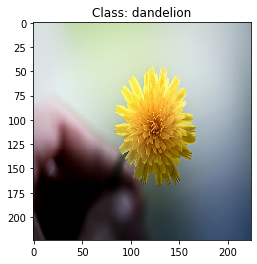

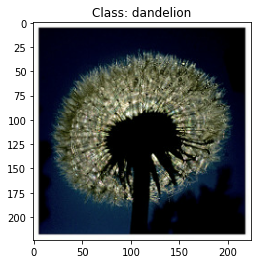

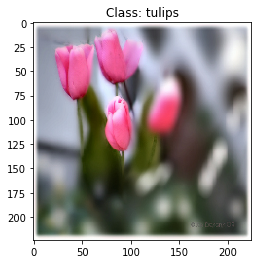

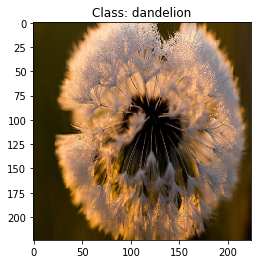

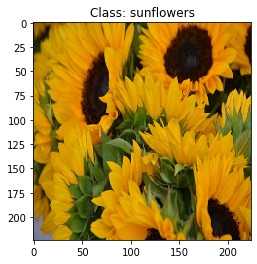

In [45]:
# display some samples
import matplotlib.pyplot as plt
def disp_samples(dataset, limit = 5):
    ds = dataset.unbatch().take(limit)
    for x in ds:
        image, class_index = x
        plt.figure()
        plt.imshow(image / 2 + 0.5)
        plt.title(f"Class: {class_names[class_index]}")

disp_samples(train_set)


In [33]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

# on fige d'abord les points des couches préentrainés
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)



Epoch 1/5
84/84 [==============================] - 24s 231ms/step - loss: 3.1811 - accuracy: 0.6438 - val_loss: 1.1196 - val_accuracy: 0.8820
Epoch 2/5
84/84 [==============================] - 18s 215ms/step - loss: 0.6783 - accuracy: 0.9030 - val_loss: 0.5932 - val_accuracy: 0.9060
Epoch 3/5
84/84 [==============================] - 18s 214ms/step - loss: 0.3471 - accuracy: 0.9331 - val_loss: 0.4998 - val_accuracy: 0.9300
Epoch 4/5
84/84 [==============================] - 18s 208ms/step - loss: 0.3045 - accuracy: 0.9379 - val_loss: 0.3590 - val_accuracy: 0.9400
Epoch 5/5
84/84 [==============================] - 16s 187ms/step - loss: 0.2306 - accuracy: 0.9539 - val_loss: 0.2958 - val_accuracy: 0.9580


In [34]:
# Mtn on libère les couches pour affiner l'entrainement. On diminue le learning_rate pour éviter de bouger trop les poids déjà entrainés

for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)


Epoch 1/5
84/84 [==============================] - 80s 909ms/step - loss: 0.5402 - accuracy: 0.8336 - val_loss: 0.2578 - val_accuracy: 0.9240
Epoch 2/5
84/84 [==============================] - 74s 877ms/step - loss: 0.1617 - accuracy: 0.9514 - val_loss: 0.0928 - val_accuracy: 0.9780
Epoch 3/5
84/84 [==============================] - 75s 889ms/step - loss: 0.0582 - accuracy: 0.9823 - val_loss: 0.1038 - val_accuracy: 0.9760
Epoch 4/5
84/84 [==============================] - 75s 889ms/step - loss: 0.0741 - accuracy: 0.9787 - val_loss: 0.0197 - val_accuracy: 0.9940
Epoch 5/5
84/84 [==============================] - 71s 847ms/step - loss: 0.0261 - accuracy: 0.9905 - val_loss: 0.0198 - val_accuracy: 0.9940


In [35]:
model.evaluate(test_set) # 99%

16/16 [==============================] - 3s 182ms/step - loss: 0.0270 - accuracy: 0.9940


[0.027031293138861656, 0.9940000176429749]

In [ ]:
# Si nous voulions ajouter une tâche de régression pour trouver les rectangles localisants les objets : Mais on a pas de rectangles pour le moment pour superviser
def train_localization_output():
    base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
    avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
    output = keras.layers.Dense(n_classes, activation="softmax")(avg)
    localization_output = keras.layers.Dense(4)(avg)
    model = keras.Model(inputs=base_model.input, outputs=[output, localization_output])

    # # on fige d'abord les points des couches préentrainés
    # for layer in base_model.layers:
    #     layer.trainable = False

    optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
    model.compile(
        loss=["sparse_categorical_crossentropy", "mse"],
        loss_weights=[0.8, 0.2],
        optimizer=optimizer, metrics=["accuracy"])
    history = model.fit(train_set, epochs=5, validation_data=valid_set)



# Exercice MNIST

In [22]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_train = X_train / 255
X_test = X_test / 255

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10000)


X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

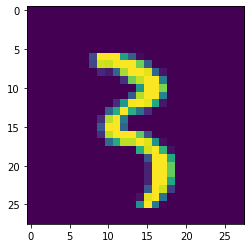

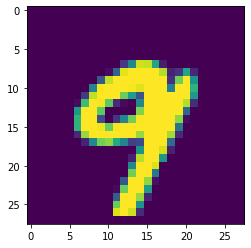

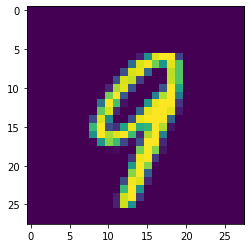

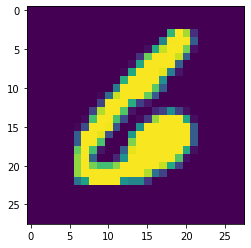

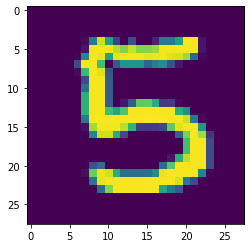

In [23]:
def display_images(images, limit = 5):
    count = 0
    for x in images:
        count += 1
        plt.figure()
        plt.imshow(x)
        if count >= limit:
            return

display_images(x_train[0:10])

In [38]:
# model = keras.models.Sequential([
#     keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
#     keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
#     keras.layers.MaxPool2D(),
#     keras.layers.Flatten(),
#     keras.layers.Dropout(0.25),
#     keras.layers.Dense(128, activation="relu"),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(10, activation="softmax")
# ])

# Ce modèle atteint 93% de précision sur 10 époques, le dropout à la fin diminue les résultats car le modèle est suffisamment simple pour ne pas trop surajuster. Le dropout ne fait que tuer sa performance.
# model = keras.models.Sequential([
#     keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
#     keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
#     # keras.layers.MaxPool2D(),
#     # keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
#     # keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
#     keras.layers.GlobalAveragePooling2D(),
#     keras.layers.Dense(128, activation="relu"),
#     # keras.layers.Dropout(0.5),
#     keras.layers.Dense(10, activation="softmax")
# ])

# Ce modèle atteint les 99,5% sur le train, et 99% sur le test. Ceci sans dropout. Cette différence de précision est peut-être un petit sur-ajustement ?
# model = keras.models.Sequential([
#     keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
#     keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
#     keras.layers.MaxPool2D(),
#     keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
#     keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
#     keras.layers.GlobalAveragePooling2D(),
#     keras.layers.Dense(128, activation="relu"),
#     # keras.layers.Dropout(0.5),
#     keras.layers.Dense(10, activation="softmax")
# ])

# With dropout, we have only 99.1% on train, but 99.3% on test. So dropout, did make it better on generalization
# model = keras.models.Sequential([
#     keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
#     keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
#     keras.layers.MaxPool2D(),
#     keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
#     keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
#     keras.layers.GlobalAveragePooling2D(),
#     keras.layers.Dense(128, activation="relu"),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(10, activation="softmax")
# ])

# Now we have only 99.1% on the test set. Maybe we have added too many batchNormalization, regularizing the model too much ?
# model = keras.models.Sequential([
#     keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
#     keras.layers.BatchNormalization(),
#     keras.layers.MaxPool2D(),
#     keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
#     keras.layers.BatchNormalization(),
#     keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
#     keras.layers.BatchNormalization(),
#     keras.layers.GlobalAveragePooling2D(),
#     keras.layers.Dense(128, activation="relu"),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(10, activation="softmax")
# ])


model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
    metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))
model.evaluate(X_test, y_test)

Epoch 1/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.4920 - accuracy: 0.8461 - val_loss: 0.1216 - val_accuracy: 0.9624
Epoch 2/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0959 - accuracy: 0.9726 - val_loss: 0.1988 - val_accuracy: 0.9367
Epoch 3/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0596 - accuracy: 0.9816 - val_loss: 0.1692 - val_accuracy: 0.9533
Epoch 4/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0566 - accuracy: 0.9837 - val_loss: 0.0509 - val_accuracy: 0.9844
Epoch 5/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0462 - accuracy: 0.9870 - val_loss: 0.0728 - val_accuracy: 0.9782
Epoch 6/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.0387 - accuracy: 0.9894 - val_loss: 0.0340 - val_accuracy: 0.9893
Epoch 7/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.0368 - accuracy: 0.9888 - val_loss: 0.0422 - val_ac

[0.030723238363862038, 0.9904000163078308]

# Exercice de classification de grandes images par transfer learning

In [2]:
import tensorflow_datasets as tfds
import tensorflow as tf
import tensorflow.keras as keras

dataset, info = tfds.load("cats_vs_dogs", as_supervised=True, with_info=True)


In [3]:
dataset_size = info.splits["train"].num_examples #3670
class_names = info.features["label"].names #["dandelion", "daisy", ...]
n_classes = info.features["label"].num_classes #5

print(f"dataset_size: {dataset_size}")
print(f"class_names: {class_names}")
print(f"n_classes: {n_classes}")
# print(f"info: {info}")

dataset_size: 23262
class_names: ['cat', 'dog']
n_classes: 2


In [4]:
def disp_dataset(ds, limit=None, print_elements=True):
    count = 0

    for x in ds:
        count += 1
        if print_elements:
            print(x)
        if limit is not None and count >= limit:
            break
    print(f"Count:{count}")

def batch_sets(list_ds):
    my_list = []
    for x in list_ds:
        new_ds = x.batch(32).prefetch(1)
        my_list.append(new_ds)
    return my_list

# Redimensionner l'image

def preprocess(image, label):
    # label useless, but we still get it through iteration
    final_image = image / 255
    final_image = tf.image.resize(image, [224, 224])
    # final_image = keras.applications.xception.preprocess_input(final_image)
    return final_image, label

ds = dataset["train"]
ds = ds.shuffle(int(dataset_size / 3)).map(preprocess, num_parallel_calls=5)
ds = ds.shuffle(int(dataset_size / 3))

test_size = int(dataset_size / 10)
# test_size = 5000
test_set = ds.take(test_size)
train_set = ds.skip(test_size)

valid_set = train_set.take(test_size)
train_set = train_set.skip(test_size)

[test_set, train_set, valid_set] = batch_sets([test_set, train_set, valid_set])
intput_size = [x for (x,y) in train_set.take(1)][0].shape[1:]


In [7]:
disp_dataset(train_set.take(1))

def disp_samples(dataset, limit = 5):
    ds = dataset.unbatch().take(limit)
    for x in ds:
        image, class_index = x
        plt.figure()
        plt.imshow(image / 2 + 0.5)
        plt.title(f"Class: {class_names[class_index]}")

disp_samples(train_set)

(<tf.Tensor: shape=(375, 500, 3), dtype=uint8, numpy=
array([[[ 56,  42,   0],
        [ 79,  65,  18],
        [ 97,  83,  38],
        ...,
        [156, 163, 156],
        [156, 163, 156],
        [156, 163, 156]],

       [[ 70,  56,  11],
        [ 84,  70,  25],
        [ 93,  79,  34],
        ...,
        [156, 163, 156],
        [156, 163, 156],
        [156, 163, 156]],

       [[ 87,  72,  29],
        [ 89,  74,  31],
        [ 86,  71,  28],
        ...,
        [156, 163, 156],
        [156, 163, 156],
        [156, 163, 156]],

       ...,

       [[ 85,  82,  77],
        [ 86,  83,  78],
        [ 86,  83,  76],
        ...,
        [ 64,  67,  74],
        [ 62,  65,  72],
        [ 67,  70,  77]],

       [[ 82,  79,  74],
        [ 83,  80,  73],
        [ 83,  80,  73],
        ...,
        [ 59,  62,  69],
        [ 62,  65,  72],
        [ 66,  69,  76]],

       [[ 81,  78,  71],
        [ 82,  79,  72],
        [ 82,  79,  72],
        ...,
        [ 57,  60,  

ValueError: Value Tensor("args_1:0", shape=(), dtype=int64) has insufficient rank for batching.

In [48]:
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)

# on fige d'abord les points des couches préentrainés
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)


# Mtn on libère les couches pour affiner l'entrainement. On diminue le learning_rate pour éviter de bouger trop les poids déjà entrainés. Toutefois, on voit ici que nous avons un score très bon même sans ré-entrainer les couches

for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, epochs=5, validation_data=valid_set)

model.evaluate(test_set) # 99%

Epoch 1/5
26/26 [==============================] - 8s 229ms/step - loss: 0.3641 - accuracy: 0.8328 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
26/26 [==============================] - 5s 176ms/step - loss: 0.0085 - accuracy: 0.9988 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 3/5
26/26 [==============================] - 5s 178ms/step - loss: 3.4266e-04 - accuracy: 0.9995 - val_loss: 5.1774e-05 - val_accuracy: 1.0000
Epoch 4/5
26/26 [==============================] - 5s 176ms/step - loss: 1.9330e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
26/26 [==============================] - 5s 176ms/step - loss: 2.0468e-06 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 1/5
26/26 [==============================] - 24s 814ms/step - loss: 0.3767 - accuracy: 0.9382 - val_loss: 2.0160 - val_accuracy: 0.8529
Epoch 2/5
26/26 [==============================] - 20s 764ms/step - loss: 0.0143 - accuracy: 0.9970 - val_loss: 0.1673 - val_

[4.955257963956683e-07, 1.0]

# trying to train custom model on train set

In [5]:
import numpy as np

keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

## Pour un tel model, le training prend trop de temps. La taille d'entrée étant de 200 x 200, Nous avons trop de paramètres dans ce modèle. Nous prenons bien 2 min par epoch
# Paramètres: 277,962
# model = keras.models.Sequential([
#     keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu", input_shape=intput_size),
#     keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
#     keras.layers.MaxPool2D(),
#     keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
#     keras.layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),
#     keras.layers.GlobalAveragePooling2D(),
#     keras.layers.Dense(128, activation="relu"),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(10, activation="softmax")
# ])

# Paramètres: 233,098
# 76% sur 10 epochs
model = createResNet34()

# Paramètres : 285 642
# Précision : 50%
# model = keras.models.Sequential([
#     keras.layers.Conv2D(64, kernel_size=7, strides=2, padding="same", activation="relu", input_shape=intput_size),
#     keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="same", activation="relu"),
#     keras.layers.MaxPool2D(),
#     keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="same", activation="relu"),
#     keras.layers.Conv2D(128, kernel_size=3, strides=2, padding="same", activation="relu"),
#     keras.layers.GlobalAveragePooling2D(),
#     keras.layers.Dense(64, activation="relu"),
#     keras.layers.Dropout(0.5),
#     keras.layers.Dense(10, activation="softmax")
# ])

model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=7, strides=2, padding="same", activation="relu", input_shape=intput_size),
    keras.layers.DepthwiseConv2D(64, kernel_size=3, strides=2, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.DepthwiseConv2D(128, kernel_size=3, strides=2, padding="same", activation="relu"),
    keras.layers.DepthwiseConv2D(128, kernel_size=3, strides=2, padding="same", activation="relu"),
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001),
    metrics=["accuracy"])

model.summary()

def train_model(model):
    model.fit(train_set, epochs=10, validation_data=valid_set)
    model.evaluate(test_set)

train_model(model)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 112, 112, 64)      9472      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 56, 56, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 7, 7, 128)         147584    
_________________________________________________________________
global_average_pooling2d_1 ( (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)               

KeyboardInterrupt: 

In [56]:
    model.evaluate(test_set)


157/157 [==============================] - 7s 33ms/step - loss: 0.6426 - accuracy: 0.7590


[0.642633855342865, 0.7590000033378601]